In [1]:
import numpy as np
import ast

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt
import matplotlib

from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils

import process_data
import config
import network

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Evaluating an ANN Model Trained with a Subset of Measurements
This example demonstrates the evaluation of an ANN model trained using a subset of 66 measurements.

Load a test data dMRI and its mask. User should change to their own path that store 'data.nii.gz' and 'nodif_brain_mask.nii.gz'

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz') 
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

In [4]:
scan_100307.shape

(145, 174, 145, 288)

In [5]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')
bvals_all_100307.shape

(288,)

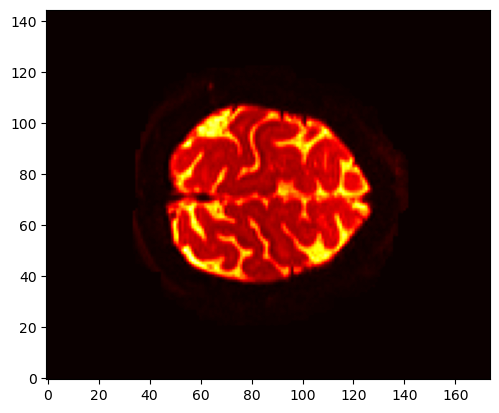

In [19]:
# im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
# plt.colorbar(im)

selected_dwi = scan_100307[:, :, :, 0]
slice_to_display = selected_dwi[:, :, 100]
plt.imshow(slice_to_display, origin='lower', cmap=matplotlib.colormaps["hot"])

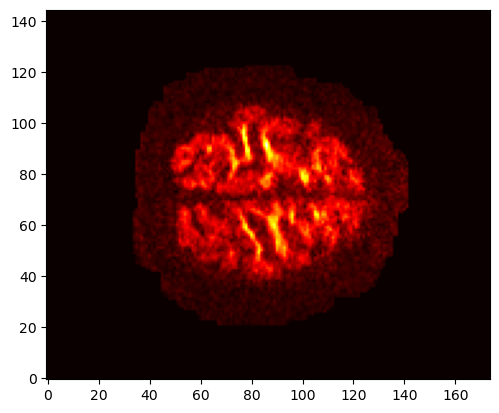

In [21]:
selected_dwi = scan_100307[:, :, :, 15]
slice_to_display = selected_dwi[:, :, 100]
plt.imshow(slice_to_display, origin='lower', cmap=matplotlib.colormaps["hot"])

In [24]:
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [25]:
mask_100307_long_pro.shape

(3658350, 1)

Load the normalized dMRI of this test data and the files contain b-values and gradient directions. 

In [26]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')

In [27]:
normalized_scan_100307_full.shape

(740145, 288)

'selected_indice' is the indices of the measurement subset. B-values and gradient directions correspond to the 'selected_indice' together form a subset accquisition protocol.
The example here is a subset with 66 measurements. You can find the list in acquisition_scheme/66-measurements.txt

In [74]:
with open("acquisition_scheme/66_measurements.txt", "r") as file:
    txt = file.read()
    selected_indiced = ast.literal_eval(txt)

In [8]:
bvals_100307_selected = bvals_all_100307[selected_indice]*1e-3
normalized_scan_100307_sub = normalized_scan_100307_full[:,selected_indice]
n_100307_sub = n_all_100307[:,selected_indice]

big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(66, 3)


Load the saved ANN model trained with 66 measurements

In [16]:

net = network.BallStickNet(gradient_directions_100307_sub, b_values_100307_sub, device)
state_dict = torch.load("saved_ANN/model_66_measurements.pt", map_location=torch.device('cpu'))
net.load_state_dict(state_dict)
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=66, out_features=66, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=66, out_features=66, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=66, out_features=66, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=66, out_features=66, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=66, out_features=66, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=66, out_features=66, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=66, out_features=5, bias=True)
  )
)

Ball-and-Stick model parameters estimation

In [10]:

with torch.no_grad():
    X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)))


## Parameter Maps generated by 66 measurements

Stick diffusivity map

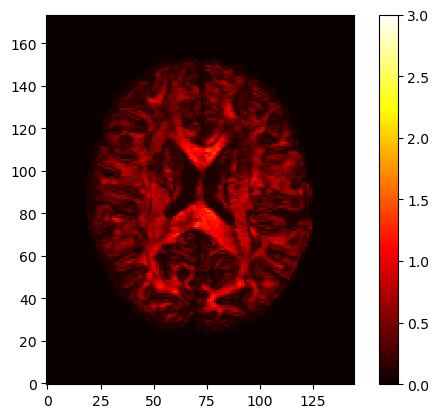

In [11]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

Ball diffusivity map

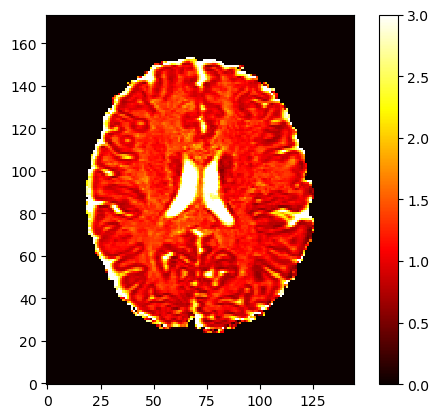

In [12]:
lambda_iso_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Stick volume fraction map

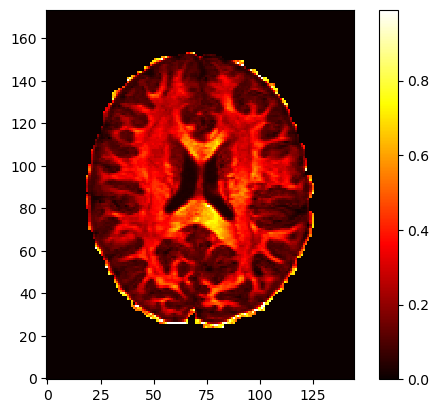

In [13]:
volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Ball volume fraction map

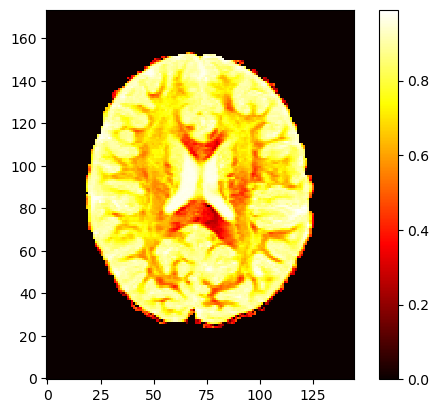

In [14]:
volume_1_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred, (145, 174, 145))
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Stick angle map (directions encoded colour)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


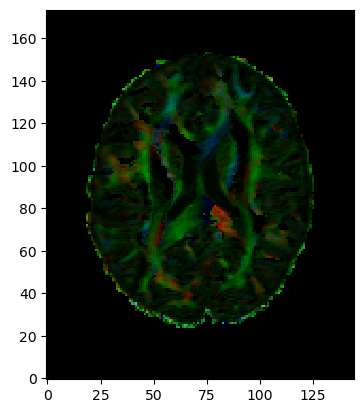

In [15]:
mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
no_bg_indices = np.argwhere(mask_for_mu == 1)
resume_mu_100307 = np.copy(mask_for_mu)
mu_cart_100307_pred_cp = np.copy(mu_cart_100307_pred.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307[index[0], index[1]] = mu_cart_100307_pred_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped = resume_mu_100307.reshape((145, 174, 145, 3))

volume_0_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred, (145, 174, 145))
volume_0_100307_slice = volume_0_100307_pred_3d[:,:,70]
r = np.repeat(volume_0_100307_slice[:, :, np.newaxis], 3, axis=2)
dir = mu_100307_reshaped[:,:,70,:] * r

plt.imshow(np.rot90(dir, 3), origin='lower', interpolation='nearest')

## Test a ANN model trained using full measurements

In [18]:
big_b_indices_100307 = np.where(bvals_all_100307 != 5.)[0]

bvals_100307_no_b5 = bvals_all_100307[big_b_indices_100307]*1e-3
normalized_scan_100307_no_b5 = normalized_scan_100307_full[:, big_b_indices_100307]
n_100307_no_b5 = n_all_100307[:,big_b_indices_100307].T

b_values_100307 = torch.FloatTensor(bvals_100307_no_b5)
gradient_directions_100307 = torch.FloatTensor(n_100307_no_b5)

In [19]:
net_reference = network.BallStickNet(gradient_directions_100307, b_values_100307, device)
state_dict = torch.load("saved_ANN/model_full_measurements.pt", map_location=torch.device('cpu'))
net_reference.load_state_dict(state_dict)
net_reference.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [21]:
with torch.no_grad():
    X_100307_pred_ref,theta_100307_pred_ref, phi_100307_pred_ref, mu_cart_100307_pred_ref, lambda_par_100307_pred_ref, lambda_iso_100307_pred_ref, volume_0_100307_pred_ref, volume_1_100307_pred_ref = net_reference(torch.from_numpy(normalized_scan_100307_no_b5.astype(np.float32)))
    

## Parameter Maps generated by full measurements

In [22]:
lambda_par_100307_pred_ref_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred_ref, (145, 174, 145))
lambda_iso_100307_pred_ref_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_iso_100307_pred_ref, (145, 174, 145))
volume_0_100307_pred_ref_3d = process_data.back_to_3D(mask_100307_long_pro, volume_0_100307_pred_ref, (145, 174, 145))
volume_1_100307_pred_ref_3d = process_data.back_to_3D(mask_100307_long_pro, volume_1_100307_pred_ref, (145, 174, 145))

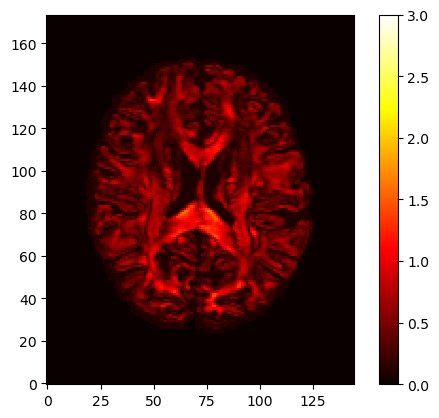

In [24]:
im = plt.imshow(lambda_par_100307_pred_ref_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

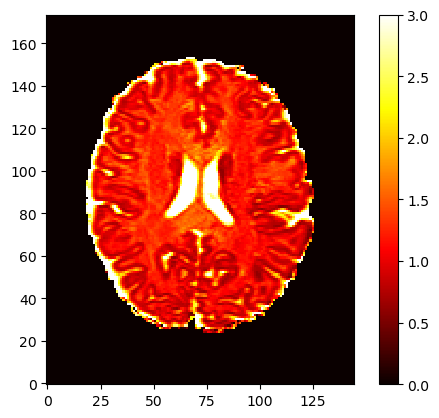

In [25]:
im = plt.imshow(lambda_iso_100307_pred_ref_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

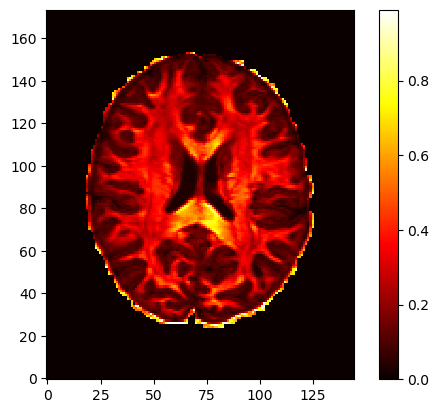

In [26]:
im = plt.imshow(volume_0_100307_pred_ref_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

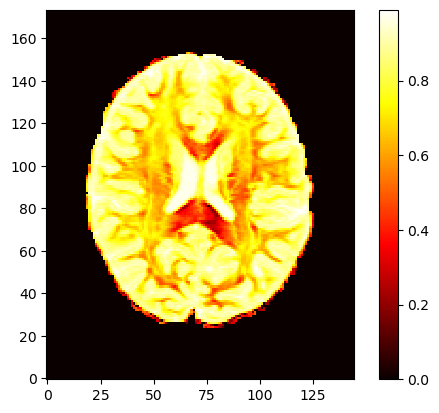

In [27]:
im = plt.imshow(volume_1_100307_pred_ref_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

In [28]:
mask_for_mu = np.repeat(mask_100307_long_pro, 3, axis=1)
no_bg_indices = np.argwhere(mask_for_mu == 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


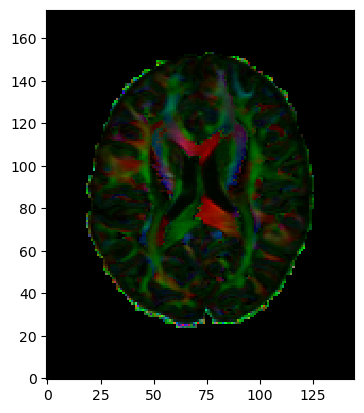

In [30]:
resume_mu_100307_ref = np.copy(mask_for_mu)
mu_cart_100307_pred_ref_cp = np.copy(mu_cart_100307_pred_ref.T.detach().numpy())

for i, index in enumerate(no_bg_indices):
    try:
        resume_mu_100307_ref[index[0], index[1]] = mu_cart_100307_pred_ref_cp[i // 3, index[1]]
    except IndexError as e:
        print(i)
        print(index)
        break
        
mu_100307_reshaped_ref = resume_mu_100307_ref.reshape((145, 174, 145, 3))

volume_0_100307_ref_slice = volume_0_100307_pred_ref_3d[:,:,70]
r_ref = np.repeat(volume_0_100307_ref_slice[:, :, np.newaxis], 3, axis=2)
dir_map_ref = mu_100307_reshaped_ref[:,:,70,:] * r_ref

plt.imshow(np.rot90(dir_map_ref, 3), origin='lower', interpolation='nearest')

## Compares the parameter maps derived from a subset of measurements with those obtained from the full set of measurements

The evaluation of the stick and ball diffusivity, as well as the partial volume fractions, is carried out using the Mean Squared Error (MSE) metric. To compare the predicted stick angles obtained from a subset of measurements with those obtained from the full measurements, the cosine similarity metric is employed.

In [31]:
mse = torch.nn.MSELoss(reduction='mean')
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

In [32]:
lambda_par_mse = mse(lambda_par_100307_pred_ref,lambda_par_100307_pred)
lambda_iso_mse = mse(lambda_iso_100307_pred_ref,lambda_iso_100307_pred)
volume_0_mse = mse(volume_0_100307_pred_ref,volume_0_100307_pred)
volume_1_mse = mse(volume_1_100307_pred_ref,volume_1_100307_pred)
print(lambda_par_mse)
print(lambda_iso_mse)
print(volume_0_mse)
print(volume_1_mse)
output = cos(mu_cart_100307_pred_ref, mu_cart_100307_pred)
print(torch.mean(output))
print(torch.std(output))

tensor(0.0097)
tensor(0.0188)
tensor(0.0006)
tensor(0.0006)
tensor(0.7067)
tensor(0.5192)


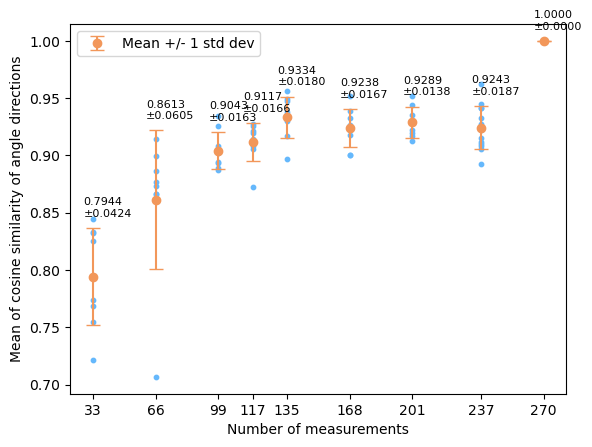

In [33]:

sub_33 = [0.7739,0.7550,0.8251,0.8331,0.8327,0.8448,0.7214,0.7688]
sub_66 = [0.8767,0.8668,0.8998,0.8734,0.9147,0.8862,0.8663,0.7067]
sub_99 = [0.8936,0.9082,0.9258,0.9023,0.8892,0.9344,0.8871,0.8939]
sub_117 = [0.9195,0.8722,0.9079,0.9254,0.9276,0.9056,0.9214,0.9140]
sub_135 = [0.9168,0.9491,0.9332,0.8970,0.9298,0.9559,0.9474,0.9383]
sub_168 = [0.9515,0.9268,0.9329,0.9389,0.9002,0.9001,0.9221,0.9180]
sub_201 = [0.9220,0.9124,0.9518,0.9200,0.9439,0.9167,0.9352]
sub_237 = [0.9416,0.9446,0.9087,0.9273,0.9219,0.9058,0.9411,
           0.8929,0.9098,0.9331,0.9116,0.9623,0.9151]
full_270 = [1.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] + 0.01,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('Mean of cosine similarity of angle directions')
ax.set_xticks(x_values)
ax.legend()

plt.show()


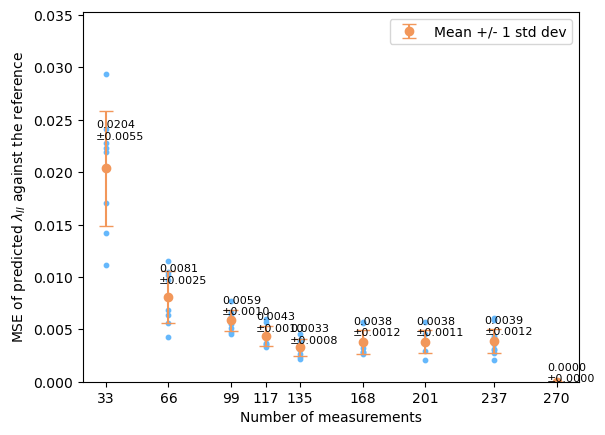

In [38]:

sub_33 = [0.0171,0.0223,0.0294,0.0111,0.0219,0.0142,0.0241,0.0228]
sub_66 = [0.0115,0.0105,0.0068,0.0064,0.0043,0.0056,0.0102,0.0097]
sub_99 = [0.0055,0.0051,0.0047,0.0046,0.0067,0.0062,0.0077,0.0065]
sub_117 = [0.0035,0.0057,0.0036,0.0037,0.0043,0.0045,0.0033,0.0060]
sub_135 = [0.0040,0.0024,0.0039,0.0046,0.0030,0.0022,0.0035,0.0026]
sub_168 = [0.0028,0.0032,0.0040,0.0026,0.0057,0.0056,0.0028,0.0037]
sub_201 = [0.0037,0.0057,0.0021,0.0040,0.0046,0.0038,0.0029]
sub_237 = [0.0031,0.0061,0.0059,0.0036,0.0042,0.0027,0.0030,0.0044,0.0039,0.0021,0.0038]
full_270 = [0.]

x_values = [33, 66, 99,117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10,c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 0.5,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE of predicted ' + r'$\lambda_{II}$' + ' against the reference')

ax.set_xticks(x_values)
ax.legend()

ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)

plt.show()

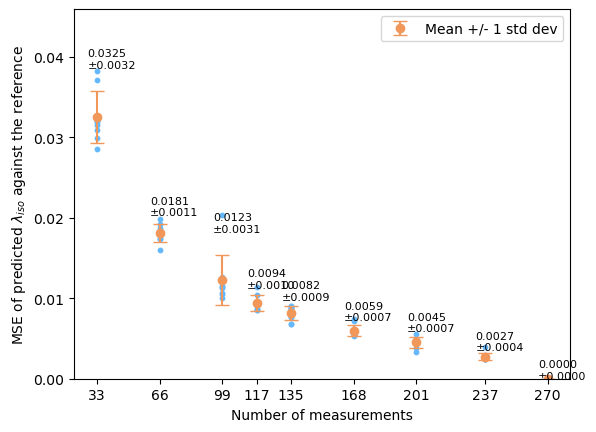

In [37]:

sub_33 = [0.0299,0.0372,0.0383,0.0286,0.0319,0.0309,0.0320,0.0315]
sub_66 = [0.0179,0.0199,0.0175,0.0160,0.0185,0.0174,0.0192,0.0188]
sub_99 = [0.0204,0.0114,0.0101,0.0113,0.0126,0.0106,0.0105,0.0115]
sub_117 = [0.0087,0.0090,0.0086,0.0085,0.0091,0.0114,0.0104]
sub_135 = [0.0088,0.0068,0.0077,0.0091,0.0088,0.0068,0.0090,0.0077,0.0087]
sub_168 = [0.0056,0.0054,0.0056,0.0062,0.0058,0.0055,0.0072,0.0074,0.0057,0.0057,0.0053]
sub_201 = [0.0049,0.0056,0.0049,0.0038,0.0048,0.0033,0.0043]
sub_237 = [0.0026,0.0026,0.0040,0.0025,0.0026,0.0025,0.0029,0.0024,0.0027,0.0027,0.0024]
full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]


fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10,c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE of predicted ' + r'$\lambda_{iso}$' + ' against the reference')
ax.set_xticks(x_values)
ax.legend()

ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)

plt.show()

[0.0011625, 0.0005, 0.0003125, 0.000225, 0.00017500000000000003, 0.0001625, 0.00017142857142857145, 0.00017181818181818186, 0.0]
[0.00023946555075835023, 0.00015, 5.9947894041409e-05, 4.330127018922192e-05, 4.330127018922193e-05, 4.8412291827592714e-05, 4.517539514526257e-05, 4.608651583867845e-05, 0.0]


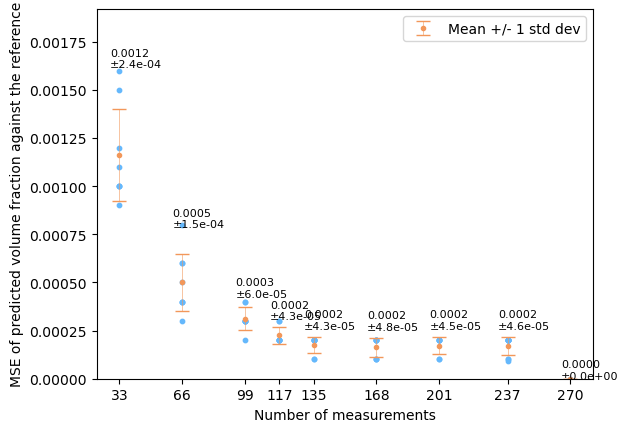

In [39]:

sub_33 = [0.0010,0.0011,0.0016,0.0009,0.0015,0.0010,0.0012,0.0010]
sub_66 = [0.0005,0.0008,0.0004,0.0004,0.0003,0.0004,0.0006,0.0006]
sub_99 = [0.0004,0.0003,0.0002,0.0003,0.0003,0.0003,0.0003,0.0004]
sub_117 = [0.0002,0.0003,0.0002,0.0002,0.0002,0.0003,0.0002,0.0002]
sub_135 = [0.0002,0.0001,0.0002,0.0002,0.0002,0.0001,0.0002,0.0002]
sub_168 = [0.0001,0.0002,0.0001,0.0001,0.0002,0.0002,0.0002,0.0002]
sub_201 = [0.0002,0.0002,0.0001,0.0002,0.0002,0.0002,0.0001]
sub_237 = [0.0002,0.0002,0.0002,0.0002,0.0002,0.0001,0.0001,0.0002,0.0002,0.00009,0.0002]
full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]


fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10,c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', elinewidth=0.4, markersize=3, capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.1e}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE of predicted volume fraction against the reference')
ax.set_xticks(x_values)
ax.legend()

# Adjust the y-axis limits to make sure all text is visible
ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)

plt.show()



## Compares the parameter maps derived from a subset of measurements with those obtained from the full set of measurements.

The evaluation maps are carried out using the SSIM and MSE metric respectively

In [40]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [41]:
def get_ssim_mse(pmap1, pmap2):
    ssim_val = ssim(pmap1, pmap2)
    mse_val = mean_squared_error(pmap1, pmap2)
    return ssim_val, mse_val

In [43]:
print(get_ssim_mse(lambda_par_100307_pred_ref_3d, lambda_par_100307_pred_3d))
print(get_ssim_mse(lambda_iso_100307_pred_ref_3d, lambda_iso_100307_pred_3d))
print(get_ssim_mse(volume_0_100307_pred_ref_3d, volume_0_100307_pred_3d))
print(get_ssim_mse(volume_1_100307_pred_ref_3d, volume_1_100307_pred_3d))

ssim_val_dir_map = ssim(dir_map_ref, dir, channel_axis=2)
mse_val_dir_map = mean_squared_error(dir_map_ref, dir)
print(ssim_val_dir_map, mse_val_dir_map)

(0.9645809942998367, 0.001956798073745597)
(0.9892653788721446, 0.003812277787770844)
(0.9941363252651608, 0.0001127767016251804)
(0.9945206637985119, 0.00011277670129243148)
0.7702895625751341 0.009430982035789157


[0.935485146788513, 0.9714477328059565, 0.9805202239202315, 0.9852143890349034, 0.9888180373887105, 0.9878519444271021, 0.9879648453131898, 0.9882361210476789, 1.0]
[0.013058787493006714, 0.007947153541857543, 0.003149624873161051, 0.0024496656749587063, 0.00207464067905366, 0.0029548243024378872, 0.002938421065200417, 0.0032991366953522452, 0.0]


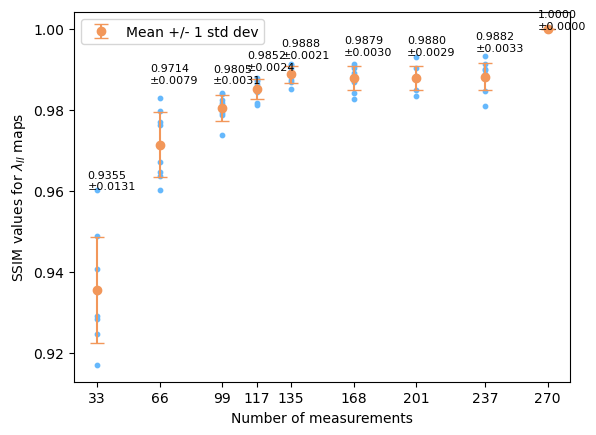

In [46]:

sub_33 = [0.9408079730313061,0.9283737223420526,0.917001927433641,
          0.9600996012081172,0.9350945089488378,0.9488461657907362,
          0.9289861968250045,0.9246710787284094]

sub_66 = [0.9603050365387841,0.9635894555555315,0.9770886441605771,
          0.976358519104759,0.9828318927759545,0.9796957438747812,
         0.9671315761374278,0.9645809942998367]
sub_99 = [0.981687427501743,0.9823401833552099,0.9841646654762451,
          0.9839208253354159,0.9787783469152002,0.980223737383996,
          0.9738059845659093,0.9792406208281325]

sub_117 = [0.987387918577901,0.981579719339735,0.9871867924596432,
          0.9864943994380883,0.9854400866494604,0.9844911911378724,
           0.9879683963071378,0.9811666083693887]

sub_135 = [0.987503406294192,0.9911868438772247,0.9869048976443535,
           0.9850784831027479,0.9894636546168087,0.9913533710990359,
           0.9886324737585792,0.9904211687167419]

sub_168 = [0.9908086744667921,0.9890086614321913,0.9869542265297916,
           0.9912399438221592,0.9840926652387074,0.9826059510653077,
           0.9902665689767632,0.9878388638851047]

sub_201 = [0.9883500264273777,0.9835282057796536,0.9930064606066995,
           0.9877572291568374,0.9849410231191705,0.9877641359030278,
           0.9904068361995633]

sub_237 = [0.989857123841781,0.984669045491404,0.9808404303844498,
           0.9878338380927472,0.9887464829249595,0.9912203345960794,
           0.9899866588966624,0.9877836916588837,
           0.9933518978580425,0.9880717067317802]

full_270 = [1.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM values for ' + r'$\lambda_{II}$' + ' maps')

ax.set_xticks(x_values)
ax.legend()

plt.show()

[0.004119888533894273, 0.0018207837324938675, 0.0011859483085498931, 0.0008707292629533926, 0.0007024258845352565, 0.000767813234161434, 0.0007705955346359006, 0.000787727768680815, 0.0]
[0.0011143000329499376, 0.000829620775328618, 0.00020569629792518344, 0.00019202441512996833, 0.0001822453813478201, 0.00023535367626178078, 0.00021634098911157303, 0.00024220526365800898, 0.0]


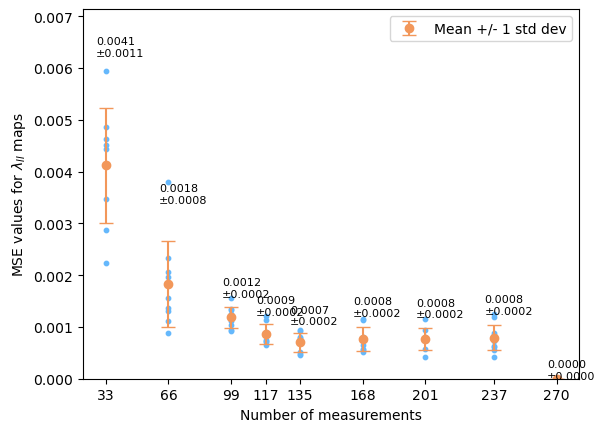

In [47]:
sub_33 = [0.0034630149924976344,0.004520779830533108,0.005947816321284351,
          0.002244036227955417,0.004427326370084418,0.0028656870906340324,
          0.004870424529133509,0.004620022909031716]
sub_66 = [0.0023293528650044797,0.0038080491707784504,0.0013753344803270344,
          0.0013009537189323252,0.000878885682399356,0.0011240019985820206,
          0.0015554870866109395,0.0020581905160646057,0.001956798073745597]
sub_99 = [0.0011172284272630416,0.0010358377033510891,0.0009420517431158123,
          0.0009253556232721099,0.0013460392770855483,0.001244766308268597,
          0.0015554870866109395,0.0013208202994320069]

sub_117 = [0.0007068567361923783,0.0011432956421566181,0.0007195416269169145,
          0.0007514271647141095,0.0008792392826153831,0.000900969326677681,
           0.0006600457479726586,0.0012044585763813975]

sub_135 = [0.0008124325383372116,0.0004815833867007364,0.0007841158669470063,
           0.0009210594175273669,0.0009333209740428957,0.000451603418105544,
           0.0007170451480832537,0.0005182463265380378]

sub_168 = [0.0005671615890244531,0.0006520848029218754,0.0008059143324869677,
           0.0005169615753636186,0.0011482645549372116,0.0011399651837821568,
           0.0005641853169226962,0.0007479685178524923]

sub_201 = [0.0007444790038328558,0.0011457502986738863,0.00041896122139479863,
           0.0008026513866151263,0.0009333209740428957,0.0007655506652312365,
           0.0005834551926605049]
sub_237 = [0.0006351683310000283,0.0012435919896377793,0.0011996642298984029,
           0.0007339621490838501,0.0008444837879524049,0.0005504202182192982,
           0.0006031000284843172,0.0008893720522730342,0.0007801231377144109,
           0.000417296654900775,0.0007678228763246637]

full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE values for $\lambda_{II}$ maps')
ax.set_xticks(x_values)
ax.legend()
ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)


plt.show()

[0.9802716314862654, 0.9891264304034637, 0.9924568287635565, 0.9942489816211466, 0.9950620475735183, 0.996228077450117, 0.996980306691281, 0.9978480022084423, 1.0]
[0.0011320751070498783, 0.0004056570530408284, 0.0010475233827465377, 0.000335807535755827, 0.0005231272782938754, 0.0003721560168113052, 0.0004417321844519003, 0.0003936028204762595, 0.0]


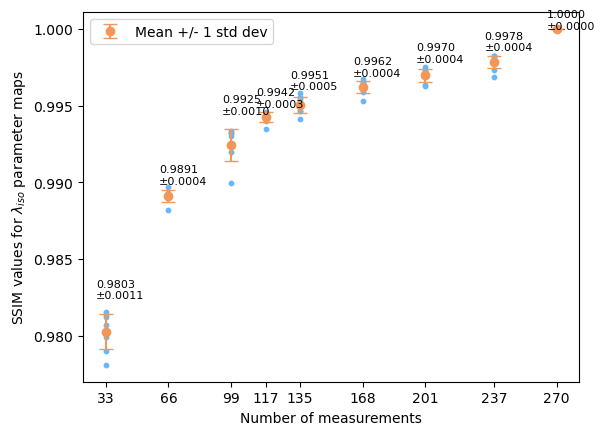

In [49]:

sub_33 = [0.9807023305690847,0.9790499152655012,0.9781143904415176,
          0.9813862570982629,0.9801879662982145,0.9815750417599298,
          0.9799523668559079,0.9812047836017043]
sub_66 = [0.9893355081022525,0.988177173658199,0.9891720623559476,
          0.9897009749581462,0.9891893606985965,0.9891656696802502,
          0.9890053149021726,0.9892653788721446]

sub_99 = [0.9899482829928631,0.9919750616589414,0.9933405119754039,
          0.9926013207448957,0.9923584435600215,0.9932133990881736,
          0.9932076536044981,0.9930099564836536]

sub_117 = [0.9944743032938514,0.9941951409624457,0.9942738900352389,
           0.9945856851263266,0.9945045630008431,0.9935124649526472,
           0.9944732389746685,0.9939725666231516]

sub_135 = [0.9941297930274636,0.9955754762156952,0.9950859688039962,
           0.9946646462852231,0.9951271881354782,0.9958349993342392,
           0.9946548733999567,0.9954234353860939]

sub_168 = [0.9963992488005681,0.9967517951112714,0.9963786048141783,
           0.9960719862263295,0.9960787193402895,0.9964718947725414,
           0.9958703906923525,0.9953019565901605,0.996304419392728,
           0.9965103557293936,0.9963694804814754]

sub_201 = [0.9970860834512543,0.9962923717247619,0.9970310069230459,
           0.9972405140869535,0.9963569676338158,0.9975336032232259,
           0.9973215997959094]
sub_237 = [0.997936636626036,0.9973504789241725,0.9968849165865658,
           0.9982281126792096,0.9977758046967073,0.9982336329064384,
           0.9979634674142417,0.9980605193049479,0.9977389881597906,
           0.9982308598842281,0.9979246071105292]
full_270 = [1.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM values for $\lambda_{iso}$ parameter maps')
ax.set_xticks(x_values)
ax.legend()
# ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)


plt.show()

[0.006584881864787878, 0.0036748221071319686, 0.002590804500082862, 0.0018803808637135344, 0.0016381885820669082, 0.0012193530104763093, 0.0009663678780560068, 0.0005485706818671739, 0.0]
[0.0006492226328896028, 0.00022974569678225633, 0.000899386592410035, 0.00019566089816019445, 0.00018408165830287226, 0.00017012802896506328, 0.0002574243730014788, 8.658403235170088e-05, 0.0]


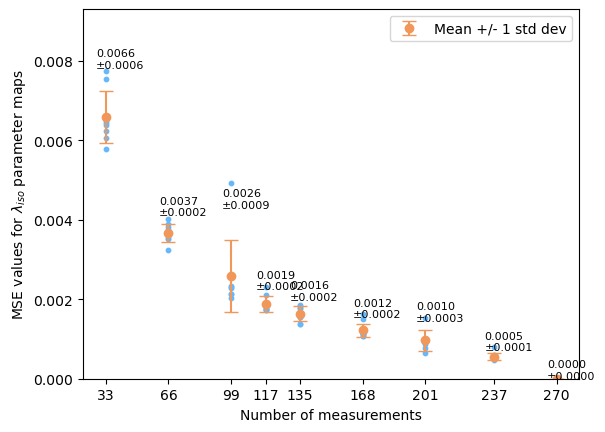

In [51]:

sub_33 = [0.006058796462411689,0.0075341557956847965,0.007754063687280807,
          0.005785497411259969,0.006445052627595346,0.006247955546132737,
          0.006476563064933205,0.0063769703230044765]
sub_66 = [ 0.0036256624419239544,0.004032366864873674,0.003538587576633769,
          0.003242927462091748,0.0037332770099427364,0.003529865278190054,
          0.0038836124356289694, 0.003812277787770844]

sub_99 = [0.004937536768707563,0.00230270844920737,0.0020421519488102577,
          0.0022962334291487937,0.002556503282121887,0.0021360309048232425,
          0.0021240797197637634,0.0023311914980800206]

sub_117 = [0.0017553916269550257,0.0018165011658204473,0.0017425848157368896,
           0.0017273880585369815,0.0018383004194672677,0.0022991930265276344,
           0.00175620685384054,0.0021074809428234874]

sub_135 = [0.001783095558729504,0.0013856451750150361,0.0015493178789233908,
           0.0018452777019279986,0.0017865396388546543,0.0013751610020910437,
           0.0018297331003538078,0.0015507386006398307]

sub_168 = [0.0011410862626840643,0.001086687834086903,0.0011236354878371017,
           0.0012642832839209858,0.0011807985798174402,0.0011156641827355094,
           0.001621054696615589,0.0015012359347466666,0.0011560780692854136,
           0.0011499471339200234,0.0010724116495897068]

sub_201 = [0.000986547800761602,0.0015306531689928797,0.000992605223662468,
           0.0007678130119349206,0.0009638105558907942,0.0006589936332980248,
           0.0008641517518513598]
sub_237 = [0.0005168948827642169,0.0005262038340440275,0.0008077780958023821,
           0.0004985029259124191,0.0005251289510978861,0.0005072744441312574,
           0.0005858323641246737,0.0004947971624138126,0.0005473905674169248,
           0.0005445580384256138, 0.0004799162344056983]
full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE values for $\lambda_{iso}$ parameter maps')
ax.set_xticks(x_values)
ax.legend()
ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)


plt.show()

[0.9886510023924391, 0.9948877280362668, 0.9965323263229888, 0.9975798606104944, 0.9981603833366968, 0.9981226029977122, 0.9983197358430245, 0.9982374694189133, 1.0]
[0.0017229699202510249, 0.0012227594050361335, 0.001051397895896618, 0.0003201010046272351, 0.00033600980608752986, 0.0003825989972958875, 0.0003199908856410771, 0.00040617986660073106, 0.0]


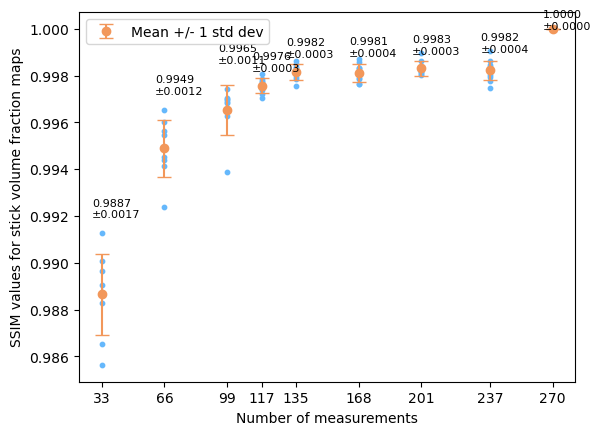

In [52]:

sub_33 = [0.9896498247209039,0.9887674022767811,0.985632976645462,
          0.9912531042131683,0.9865204444835023,0.9900762672124078,
          0.9882747111715205,0.9890332884157662]
sub_66 = [0.9945228182730643,0.9924013954219413,0.9954578204954633,
          0.9956231114089731,0.9965174979580751,0.9960390016695227,
          0.9944038537979335,0.9941363252651608]

sub_99 = [0.9938691539168764,0.9968563359531001,0.997443753480674,
          0.9970414033540113,0.9969444641560369,0.99699593490759,
          0.9968457247405624,0.996261840075059]

sub_117 = [0.9978624743269282,0.9970444635988885,0.9975967076688282,
           0.997768371749304,0.9977116075406213,0.9972081533184315,
           0.9980556359460541,0.9973914707348996]

sub_135 = [0.9979640847829091,0.9984842496056325,0.9978721386460389,
           0.997551308701821,0.9983161551888233,0.998642746968154,
           0.9980845221054429,0.9983678606947526]

sub_168 = [0.9986941191370053,0.9983173664210568,0.9979061409396313,
           0.998566330305557,0.9976514406618919,0.9976588712422816,
           0.9983422572203932,0.9978442980538802]

sub_201 = [0.9981413019212672,0.9980434647587862,0.9989614824679732,
           0.998058848784982,0.9982702551553276,0.9981378409062228,
           0.9986249569066119]
sub_237 = [0.9983717566980581,0.9982153599948131,0.9974847041014422,
           0.9983417030939918,0.9977662457549046,0.998626978068377,
           0.9984432571370395,0.9979343883403696,0.9983313349542277,
           0.9990526211028065,0.9980438143620146]
full_270 = [1.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM values for stick volume fraction maps')
ax.set_xticks(x_values)
ax.legend()

plt.show()


[0.00023378394514458428, 9.992477806234662e-05, 5.60933883354796e-05, 4.611080915645186e-05, 3.533037739782115e-05, 3.983017141226557e-05, 3.260156894092883e-05, 3.424012017772389e-05, 0.0]
[4.967893283615129e-05, 2.709440274297077e-05, 1.112899450753984e-05, 6.2157538181492165e-06, 6.405170661634071e-06, 8.403880094553125e-06, 6.060306203778647e-06, 7.66686983718507e-06, 0.0]


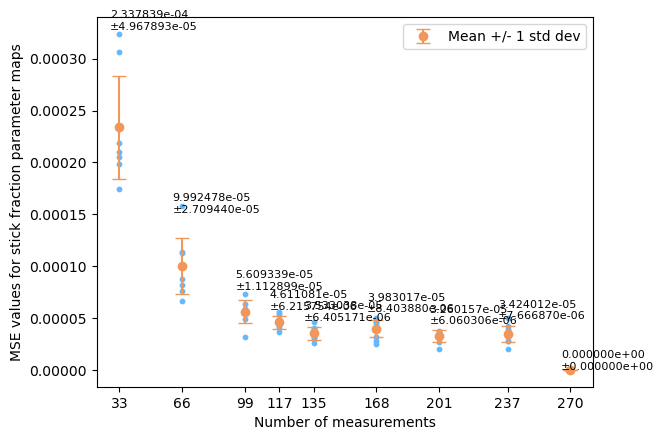

In [54]:

sub_33 = [0.0002055497862009545,0.0002187606712033215,0.00032391850519058736,
          0.00017460136016690948,0.00030635738368205807,0.00019847962776294302,
          0.00023290806282909028,0.00020969616412081]
sub_66 = [0.00010130216428692722,0.00015822415702183265,8.791048200039976e-05,
          8.226662121638068e-05,6.675471753010409e-05,7.632470722886103e-05, 
          0.00011383867358908714,0.0001127767016251804]

sub_99 = [0.0000321012989625958,6.3418104540516e-05,4.893244693508195e-05,
          5.6243868761965535e-05,5.85890197637711e-05,5.703776464100258e-05,
           5.919953560010941e-05,7.322506747879441e-05]

sub_117 = [4.046224706031161e-05,5.5794826832653466e-05,4.584120522874383e-05,
           4.2651922539925734e-05,4.4138493889261746e-05,5.4175497782630717e-05,
           3.650970523252189e-05, 4.931257468556585e-05]

sub_135 = [3.908645191216558e-05,2.9584683721293815e-05,4.06924688581804e-05,
           4.6396611002805196e-05,3.196950117616074e-05,2.5580877073625308e-05,
           3.803107319447693e-05, 3.130135224386123e-05]

sub_168 = [2.5381636004459042e-05,3.21925510325378e-05,4.849722994704621e-05, 
           4.5813912612724855e-05,4.203573656877022e-05,2.8236412366673996e-05,
           4.795714931957492e-05,4.522376573064289e-05,4.9760971436221325e-05, 
           3.183344461205535e-05,4.119907590421473e-05]

sub_201 = [3.541077346513472e-05,3.7999949375635255e-05,2.0262041677407555e-05,
           3.6823765438132565e-05,3.557263039113622e-05, 3.534016915733361e-05,
           2.680165308172186e-05]
sub_237 = [3.263364992129862e-05,3.404478739916081e-05,4.976301357430224e-05,
           3.1801765443473554e-05,4.231991308920377e-05,2.7486678575237237e-05,
           2.8041351131157365e-05,3.992613063083749e-05, 3.301973061118288e-05, 
           2.0004842196884203e-05,3.759945938222462e-05]
full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.6e}\n±{std_devs[i]:.6e}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE values for stick fraction parameter maps')
ax.set_xticks(x_values)
ax.legend()
# ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)


plt.show()

[0.9894583628758993, 0.9952077709921087, 0.9966783571264091, 0.9977239298999574, 0.9982716069708176, 0.9980400338940751, 0.9984124843150716, 0.9983298843525799, 1.0]
[0.001453377089608664, 0.0011427628369834158, 0.0011526008481893212, 0.00030784433982727774, 0.0003227275620928117, 0.00043827703657915354, 0.00030920381126968243, 0.0003877164217183372, 0.0]


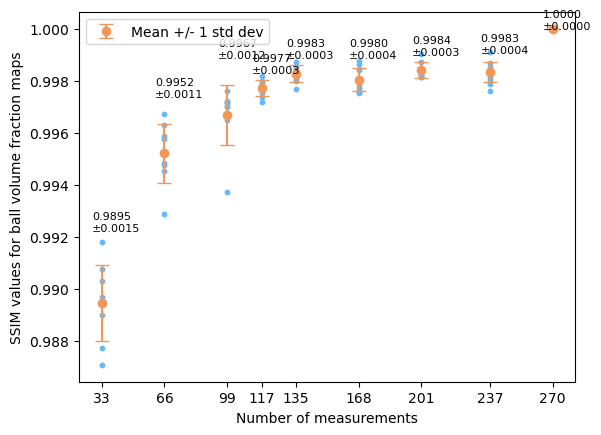

In [55]:
sub_33 = [0.9902833240173585,0.9894276471340784,0.9870655583467648,
          0.9918040953289577,0.9877069108185322,0.990741236414815,
          0.9889749690041086,0.9896631619425793]
sub_66 = [0.9948485325524737,0.9928807298476158,0.9957567668118421,
          0.9958851848072644,0.9967284535204359,0.9962831789048866,
          0.994758657693839,0.9945206637985119]
sub_99 = [0.993727384921578,0.9970476934931237,0.9976075544917719,
         0.997208611802051,0.9971576050392993,0.9971869703751026, 
         0.9970113175861106,0.9964797193022363]

sub_117 = [0.9979922191445345,0.9972024171667828,0.9977430490456627,
           0.9978999113549596,0.9978546869099434,0.9973787168024814,
           0.9981838212336052,0.9975366175416903]

sub_135 = [0.9980891318103963,0.9985846932334399,0.9979864708211834,
           0.9976885616406463,0.9984243290029585,0.9987348226456393,
           0.9981994384799119,0.9984654081323654]

sub_168 = [0.9987791104900311,0.9984109273581828,0.9975846116352393,
           0.9976949889498216,0.9980390191167591,0.9986538166483341,
           0.9975234896082399,0.9977899730953881,0.997560872601389,
           0.9984412538100008,0.9979623095214427]

sub_201 = [0.998232179109875,0.9981514748681355,0.999024971074548,
           0.99814714659908,0.9983936880208186,0.9982277854068509,
           0.9987101451261937]
sub_237 = [0.9984512775003802,0.9983064974944033,0.997621010452934,
           0.9984278687039891,0.9978782306422761,0.9986978614119647,
           0.9985349605019479,0.9980435242620093,0.9984083311003767,
           0.9991179111879221,0.9981412546201753]
full_270 = [1.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM values for ball volume fraction maps')
ax.set_xticks(x_values)
ax.legend()

plt.show()

[0.00023378394499610526, 9.992477759614553e-05, 9.220734963577544e-05, 4.611080925990176e-05, 3.5330377478039795e-05, 3.9830171518457514e-05, 3.260156898655376e-05, 3.424012007443832e-05, 0.0]
[4.967893285118958e-05, 2.709440195515412e-05, 8.672071950511094e-05, 6.215753877429678e-06, 6.405170629021389e-06, 8.403880063645791e-06, 6.06030623857185e-06, 7.666869818055245e-06, 0.0]


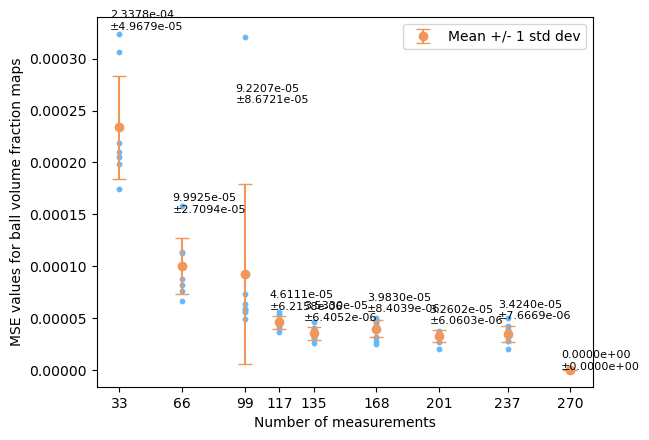

In [56]:

sub_33 = [0.00020554978607435542,0.00021876067107698765,0.0003239185054057569,
          0.000174601359942183,0.0003063573832267998, 0.0001984796275169763,
          0.00023290806225902518,0.00020969616446675791]
sub_66 = [0.00010130216405822133, 0.00015822415457700738,8.791048196862121e-05,
          8.226662099518561e-05,6.675471782693708e-05, 7.632470742631411e-05, 
          0.00011383867262444596, 0.00011277670129243148]
sub_99 = [0.00032101299000848656,6.34181044309658e-05,4.893244692566956e-05,
         5.624386842175038e-05,5.858901981698562e-05,5.70377647624403e-05,
          5.919953547369495e-05,7.32250672462104e-05]

sub_117 = [4.046224696548212e-05,5.579482704762401e-05, 4.5841205301212124e-05,
           4.2651922913786425e-05,4.413849398274471e-05, 5.4175497920349146e-05,
           3.650970518402241e-05, 4.931257476399311e-05]

sub_135 = [3.908645207339196e-05,2.9584683872695567e-05,4.069246882602531e-05,
          4.6396610934625054e-05,3.196950130893629e-05,2.5580877133097846e-05,
           3.803107341765331e-05, 3.1301352257893045e-05]

sub_168 = [2.538163628362054e-05,3.2192551068471006e-05,4.849722994534113e-05,
           4.5813912758817256e-05,4.20357365766047e-05,2.823641227113115e-05,
           4.795714930713241e-05,4.522376559231196e-05,4.976097177197501e-05,
           3.183344502394333e-05, 4.119907610368418e-05]

sub_201 = [3.541077338933851e-05,3.799994947854847e-05,2.0262041616358702e-05,
           3.68237654864067e-05,3.5572630537760816e-05,3.534016923455405e-05,
           2.680165316290904e-05]
sub_237 = [3.2633649750646696e-05,3.404478701288676e-05,4.976301358179682e-05,
           3.180176516689491e-05,4.2319913181064145e-05,2.748667867247691e-05,
           2.8041351060714622e-05, 3.9926130299620435e-05,3.3019730619155206e-05, 
           2.0004842255324614e-05,3.759945921824042e-05]
full_270 = [0.]

x_values = [33, 66, 99, 117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4e}\n±{std_devs[i]:.4e}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('MSE values for ball volume fraction maps')
ax.set_xticks(x_values)
ax.legend()
# ax.set_ylim(min(min(sub) for sub in y_values) * 0.9, max(max(sub) for sub in y_values) * 1.2)


plt.show()

[0.807193750206337, 0.8583675050399632, 0.8864467067911812, 0.8983710769916583, 0.9124971209578873, 0.9088447062694478, 0.9049435221021334, 0.9048608008901073, 1.0]
[0.021171639825376662, 0.03741868765060687, 0.014651411833517139, 0.01581123076617411, 0.018136067736075574, 0.015363773112118013, 0.01412429950344612, 0.01590717377856072, 0.0]


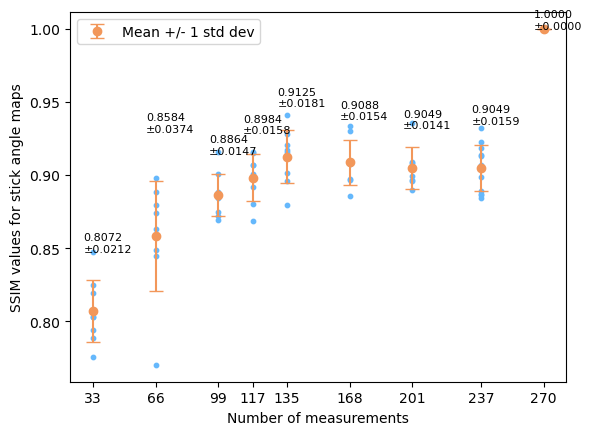

In [57]:

sub_33 = [0.8031602337672178,0.7889191714375284,0.8033047099345253,
          0.8252508904207932,0.8193506145385193,0.8472845225458562,
          0.7760105582276068,0.7942693007786487]
sub_66 = [0.8743214718983396,0.844895106044246,0.8882308511975205,
          0.8634579408179173,0.8977441987440455,0.8794243112856203,
          0.8485765977568821,0.7702895625751341]

sub_99 = [0.8695556436054105,0.8855450983264396,0.9010374260415382,
          0.8887250292613206,0.8718626557739567,0.9157726022076398,
          0.8842776408656653,0.8747975582474795]

sub_117 = [0.9155085041658602,0.8688211237122406,0.8920003053241773,
           0.9009947828542931,0.9068001718262275,0.8800380310698114,
           0.9158070558185686,0.9069986411620873]

sub_135 = [0.896071918329799,0.9281402871377017,0.901275291185863,
          0.8796714732193981,0.9209101644431348,0.9409550502367802,
           0.9172128874930396,0.9157398956173816]

sub_168 = [0.9337383648841172,0.9093768113646434,0.9078705368987968,
           0.9302333595316616,0.896680509634009,0.8856937947877178,
           0.9095252696123627,0.8976390034422743]

sub_201 = [0.8965937491352638,0.8957146987733103,0.935796608371389,
           0.899181442990601,0.9089675002004753,0.8898551896475307,
           0.9084954655963636]
sub_237 = [0.9131523953451488,0.9227117034411373,0.88715316291326,
           0.9068547780816719,0.884178125020528,0.9184847291909035,
           0.8986559753261277,0.8893322599118728,0.9138346606426158,
           0.9325864414596406,0.8865245784582721]
full_270 = [1.]

x_values = [33, 66, 99,117, 135, 168, 201, 237, 270]
y_values = [sub_33, sub_66, sub_99, sub_117, sub_135, sub_168, sub_201, sub_237, full_270]

fig, ax = plt.subplots()
for i in range(len(x_values)):
    ax.scatter([x_values[i]] * len(y_values[i]), y_values[i], s=10, c='#65b8fc')

means = [np.mean(sub) for sub in y_values]
std_devs = [np.std(sub) for sub in y_values]
print(means)
print(std_devs)

ax.errorbar(x_values, means, yerr=std_devs, fmt='o', capsize=5, color='#f2975a', label='Mean +/- 1 std dev')

# Display mean and standard deviation values
for i in range(len(x_values)):
    ax.text(x_values[i] - 5, means[i] + std_devs[i] * 1.9,
            f'{means[i]:.4f}\n±{std_devs[i]:.4f}', fontsize=8)

ax.set_xlabel('Number of measurements')
ax.set_ylabel('SSIM values for stick angle maps')
ax.set_xticks(x_values)
ax.legend()

plt.show()

## Fitting the ball-stick model using Dmipy

In [22]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

def get_fitted_parameters(scan_slice, mask_slice, bvals, gradient_directions):
    scheme = get_acquisition_scheme(bvals, gradient_directions)
    
    ball = gaussian_models.G1Ball()
    stick = cylinder_models.C1Stick()
    BAS_mod = MultiCompartmentModel(models=[stick, ball])
    
    BAS_fit = BAS_mod.fit(scheme, scan_slice, mask_slice)
    
    return BAS_fit, BAS_fit.fitted_parameters

NLLS fitting the Ball-stick model

In [59]:
import datetime
now = datetime.datetime.now()
print("Current time: ", now)
BAS_fit_100307_slice, fitted_parameters_100307_slice = get_fitted_parameters(scan_100307[:, :, 70, :], mask_100307[:,:,70], bvals_all_100307*1e6, n_all_100307.T)
now = datetime.datetime.now()
print("Current time: ", now)

Current time:  2023-04-26 04:12:28.446233
We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.264754056930542 seconds
Fitting of 10903 voxels complete in 273.17255425453186 seconds.
Average of 0.02505480640690928 seconds per voxel.
Current time:  2023-04-26 04:17:02.164185


Get stick angle parameter map generated by NLLS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(145, 174)
(145, 174, 3)


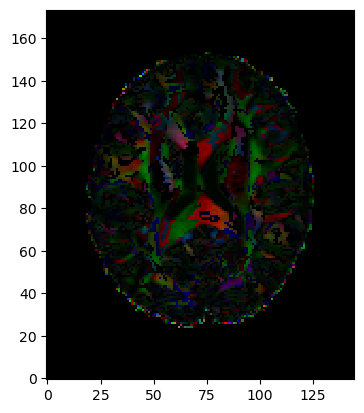

In [60]:
mu_NLLS = fitted_parameters_100307_slice.get("C1Stick_1_mu")
temp = torch.tensor(fitted_parameters_100307_slice.get("C1Stick_1_lambda_par"))
theta = torch.tensor(mu_NLLS[:,:,0])
phi = torch.tensor(mu_NLLS[:,:,1])
mu_cart = torch.zeros(3,145,174)
sintheta = torch.sin(theta)
mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
mu_cart[2,:] = torch.squeeze(torch.cos(theta))

mu_cart_T = mu_cart.permute(1,2,0)
mu_cart_T.size()

v0_nlls = fitted_parameters_100307_slice.get("partial_volume_0")
print(v0_nlls.shape)
result_v0_nlls = np.repeat(v0_nlls[:, :, np.newaxis], 3, axis=2)
print(result_v0_nlls.shape)
mu_cart_nlls_result = torch.tensor(result_v0_nlls) * mu_cart_T

plt.imshow(np.rot90(mu_cart_nlls_result,3), origin='lower', interpolation='nearest')

Get stick diffusivity map generated by NLLS

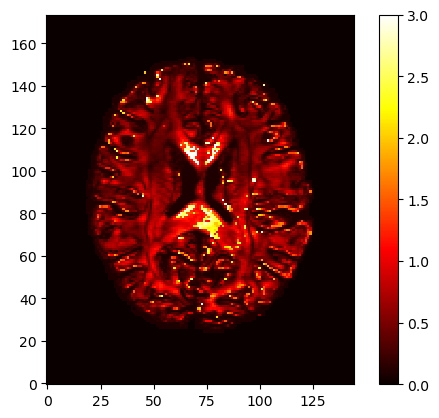

In [61]:
im = plt.imshow((fitted_parameters_100307_slice.get("C1Stick_1_lambda_par")*1e9).squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Get ball diffusivity map generated by NLLS

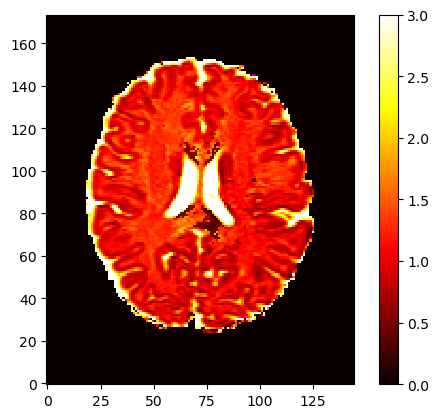

In [62]:
im = plt.imshow((fitted_parameters_100307_slice.get("G1Ball_1_lambda_iso")*1e9).squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Get stick volume fraction map generated by NLLS

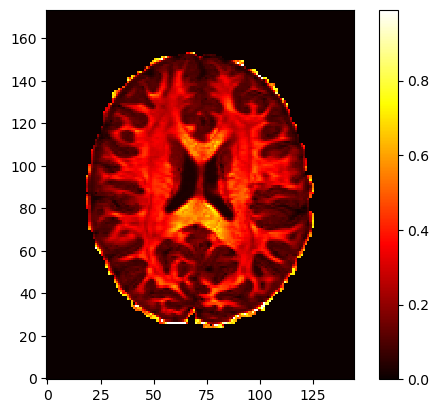

In [63]:
im = plt.imshow(fitted_parameters_100307_slice.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Get ball volume fraction map generated by NLLS

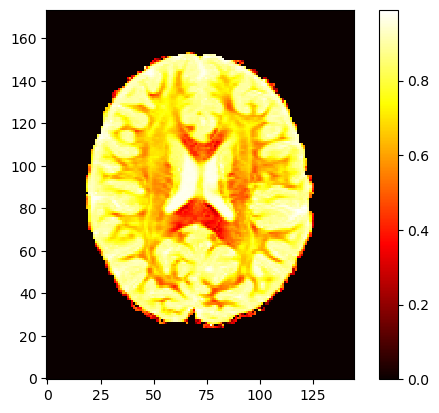

In [64]:
im = plt.imshow(fitted_parameters_100307_slice.get("partial_volume_1").squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

Compares the maps generated by Dmipy and maps generated by ANN with metrics SSIM and MSE 

In [67]:
print(get_ssim_mse(lambda_par_100307_pred_ref_3d[:,:,70], (fitted_parameters_100307_slice.get("C1Stick_1_lambda_par")*1e9)))
print(get_ssim_mse(lambda_iso_100307_pred_ref_3d[:,:,70], (fitted_parameters_100307_slice.get("G1Ball_1_lambda_iso")*1e9)))
print(get_ssim_mse(volume_0_100307_pred_ref_3d[:,:,70], fitted_parameters_100307_slice.get("partial_volume_0")))
print(get_ssim_mse(volume_1_100307_pred_ref_3d[:,:,70], fitted_parameters_100307_slice.get("partial_volume_1")))

ssim_val_dir_map = ssim(dir_map_ref, dir, channel_axis=2)
mse_val_dir_map = mean_squared_error(dir_map_ref, dir)
print(ssim_val_dir_map, mse_val_dir_map)

(0.8264468646990242, 0.046778293333937196)
(0.9702530360829761, 0.011374910789879051)
(0.9877920212431986, 0.00045634990398444724)
(0.9886607073940861, 0.0004563499015436404)
0.7702895625751341 0.009430982035789157
